<a href="https://colab.research.google.com/github/sizhky/AutoTrain/blob/segmentation/nbs/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Data and Libraries

In [1]:
%%capture
# Setup imports
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [4]:
# Setup Data
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

# If running from colab
if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

# change present working directory
if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain

!git pull origin segmentation
!git checkout segmentation

if not os.path.exists('balloon.zip'):
    !wget --quiet https://www.dropbox.com/s/tur7gzmuuzb2vzf/balloon.zip -O balloon.zip
if not os.path.exists('balloon/data/'):
    makedir('balloon')
    unzip_file('balloon.zip', 'balloon/data/')

/content/AutoTrain
From https://github.com/sizhky/AutoTrain
 * branch            segmentation -> FETCH_HEAD
Already up to date.
M	auto_train_segmentation/infer.py
M	auto_train_segmentation/train.py
Already on 'segmentation'
Your branch is up to date with 'origin/segmentation'.


## Verify Config

In [3]:
!cat config_segmentation.ini

[project]
owner: sizhky
name: baloons
location: ${project.name}
model_directory: ${project.location}/models
num_classes: 1
classes: ["Balloon"]
type: segmentation

[architecture]
model_type: torchvision.mask_rcnn
backbone: resnet34_fpn
pretrained: True
size: 384
[architecture.extra_args]

[training]
; absolute path, or path relative to AutoTrain folder
dir: balloon/data/balloon
; folder should be exported from label studio, 
; in COCO format for segmentation, i.e., 
; it should have one images dir and one results.json file
images_dir: ${training.dir}/images
annotations_file: ${training.dir}/result.json
train_ratio: 0.8

[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.scheme]
epochs: 20
lr: 1e-4
freeze_epochs: 1
resume_training_from: ${project.model_directory}/model.pt
output_path: ${project.model_directory}/model.pt

[testing]
[testing.preprocess]
@augmentations: get_val_transforms
size: ${architecture.size}
presize: 512


In [ ]:
os.environ['CONFIG'] = 'config_segmentation.ini'
!python auto_train_segmentation/train.py find-best-learning-rate

INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | __main__:<module>:34
100%|████████████████████████████████████████| 255/255 [00:00<00:00, 518.04it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 5991.20it/s]
INFO     - LR Plot is saved at baloons/find_lr_plot.png | __main__:find_best_learning_rate:80
INFO     - Suggested LRs: 0.0006309573538601399 and 1.4454397387453355e-05 | __main__:find_best_learning_rate:81


In [9]:
os.environ['CONFIG'] = 'config_segmentation.ini'
!python auto_train_segmentation/train.py train-model

2021-08-31 09:42:43.054 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18
INFO     - 
CLASSES INFERRED FROM balloon/data/balloon/result.json: <ClassMap: {'background': 0, 'balloon': 1}> | auto_train_segmentation.model:<module>:34
100% 255/255 [00:00<00:00, 3054.42it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100% 48/48 [00:00<00:00, 6703.74it/s]
100% 13/13 [00:00<00:00, 5444.97it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cre

---
## Validate

INFO     - Found 4 images | auto_train_segmentation.infer:infer:19


  0%|          | 0/4 [00:00<?, ?it/s]

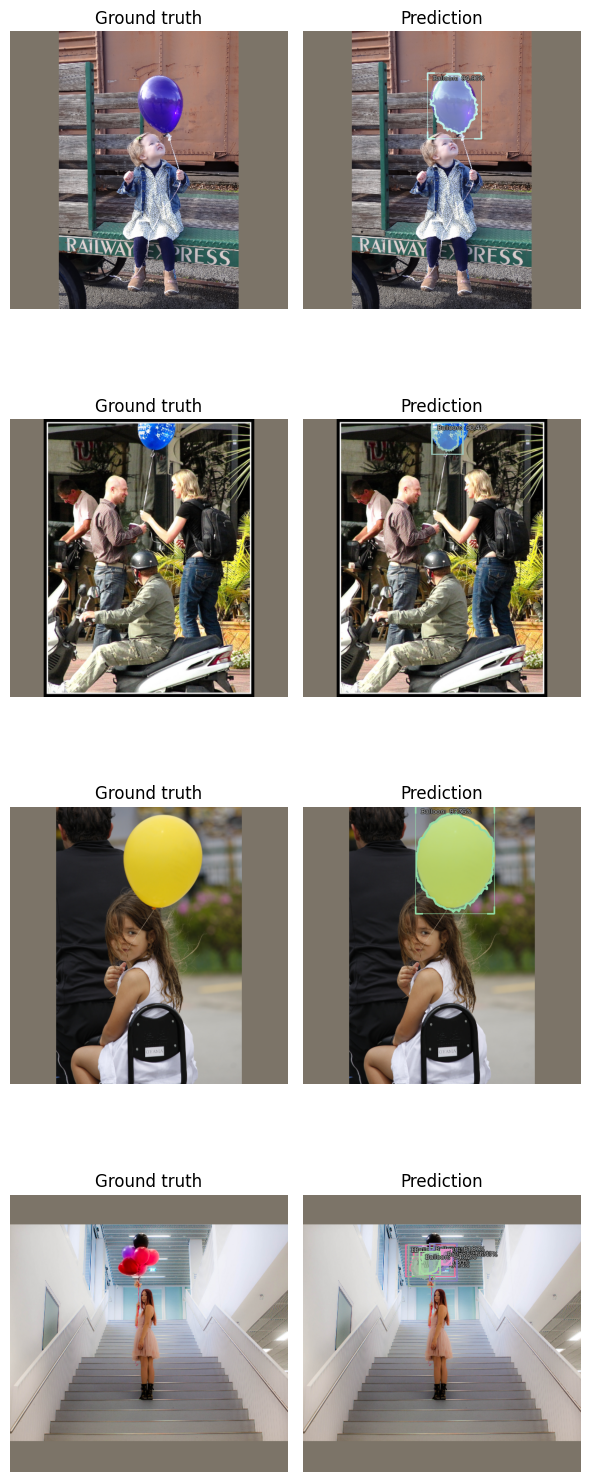

In [12]:
from auto_train_segmentation.infer import infer
infer('balloon/data/balloon/validation')